## 0.1 - Import tensorflow and list GPU devices

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if gpus:
    print("GPUs disponibles :")
    for gpu in gpus:
        print(gpu)
else:
    print("Aucun GPU disponible")

[]
Aucun GPU disponible


## 0.2 - Every imports

In [8]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tf2onnx
import onnx
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Reshape, LSTM, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tf2onnx
import onnx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchsummary import summary
import torch.onnx

## 0.3 - Setup variables

In [3]:
input_shape = 128
directory_path = './data'
augmented_path = f"{directory_path}_augment"
test_dir = "test"
onnx_model_path = "rituals.onnx"
num_epochs = 50
best_val_loss = float('inf')
patience = 5
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 0.4 - Setup functions

In [4]:
def load_and_preprocess_image(filename):
    img = Image.open(filename).convert('L')  # Conversion en niveaux de gris
    img = img.resize((input_shape, input_shape))
    img = np.array(img, dtype=np.float32)
    # Seuillage binaire
    img = np.where(img > 127, 255.0, 0.0)
    return img

def load_images_from_directory(directory_path, max_images_per_label=None):
    image_paths = []
    labels = []
    label_names = []
    
    for label in os.listdir(directory_path):
        label_path = os.path.join(directory_path, label)
        print(f"Actually load : {label} with size : {len(os.listdir(label_path))}")
        if os.path.isdir(label_path):
            label_image_count = 0
            
            for filename in os.listdir(label_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    if max_images_per_label is not None and label_image_count >= max_images_per_label:
                        break
                    image_paths.append(os.path.join(label_path, filename))
                    labels.append(label)
                    label_image_count += 1
                    if label not in label_names:
                        label_names.append(label)
    
    label_names.sort()
    return image_paths, labels, label_names

def images_to_numpy(image_paths, labels, label_names):
    images = []
    for path in tqdm(image_paths, desc="Processing images", unit="image"):
        image = load_and_preprocess_image(path)
        images.append(image)
    
    labels = [label_names.index(label) for label in labels]
    
    print("Converting images to NumPy array...")
    images = np.array(images)
    return images, np.array(labels)

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.FloatTensor(images).unsqueeze(1) / 255.0  # Normalisation [0, 1]
        self.labels = torch.LongTensor(labels)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class RitualCNN(nn.Module):
    def __init__(self, num_classes):
        super(RitualCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.3)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        self.fc1 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, num_classes)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.bn4(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(dataloader), 100. * correct / total

# Fonction de validation
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(dataloader), 100. * correct / total

## 1.0 - Collect images and classify them

In [5]:
max_images_per_label = 1000000

image_paths, labels, label_names = load_images_from_directory(
    augmented_path, 
    max_images_per_label=max_images_per_label
)
images, labels = images_to_numpy(image_paths, labels, label_names)

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

train_dataset = ImageDataset(X_train, y_train)
test_dataset = ImageDataset(X_test, y_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

num_classes = len(label_names)
print(f"Total images: {len(images)}")
print(f"Training images: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {label_names}")

Actually load : pudor with size : 250
Actually load : not_a with size : 350
Actually load : mutus with size : 300
Actually load : avarus with size : 375
Actually load : flosculus with size : 625
Actually load : acervus with size : 225
Actually load : .ipynb_checkpoints with size : 0
Actually load : regium with size : 825


Processing images: 100%|████████████████████████████████████████████████████████████████████████| 2950/2950 [00:00<00:00, 5971.91image/s]


Converting images to NumPy array...
Total images: 2950
Training images: 1888, Validation: 472, Test: 590
Number of classes: 7
Class names: ['acervus', 'avarus', 'flosculus', 'mutus', 'not_a', 'pudor', 'regium']


## 2.0 - Define model & function

In [6]:
model = RitualCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
)
summary(model, input_size=(1, input_shape, input_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
         Dropout2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
        Dropout2d-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

## 2.1 - Training !

In [7]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    if new_lr != old_lr:
        print(f"Learning rate reduced: {old_lr:.2e} -> {new_lr:.2e}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'rituals_pytorch.pth')
        print("Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:17<00:00,  3.43it/s]


Train Loss: 1.6820, Train Acc: 39.88%
Val Loss: 1.3720, Val Acc: 57.42%
Model saved!

Epoch 2/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:17<00:00,  3.47it/s]


Train Loss: 1.3805, Train Acc: 55.08%
Val Loss: 1.0801, Val Acc: 66.31%
Model saved!

Epoch 3/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.27it/s]


Train Loss: 1.2188, Train Acc: 58.79%
Val Loss: 0.9746, Val Acc: 65.89%
Model saved!

Epoch 4/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:17<00:00,  3.40it/s]


Train Loss: 1.1114, Train Acc: 61.60%
Val Loss: 0.8616, Val Acc: 68.22%
Model saved!

Epoch 5/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:17<00:00,  3.42it/s]


Train Loss: 1.0284, Train Acc: 64.72%
Val Loss: 0.8158, Val Acc: 68.43%
Model saved!

Epoch 6/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:17<00:00,  3.40it/s]


Train Loss: 0.9654, Train Acc: 66.37%
Val Loss: 0.7564, Val Acc: 69.28%
Model saved!

Epoch 7/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:17<00:00,  3.46it/s]


Train Loss: 0.9370, Train Acc: 66.47%
Val Loss: 0.7202, Val Acc: 70.97%
Model saved!

Epoch 8/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.22it/s]


Train Loss: 0.8406, Train Acc: 70.50%
Val Loss: 0.6640, Val Acc: 73.94%
Model saved!

Epoch 9/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.26it/s]


Train Loss: 0.8420, Train Acc: 68.43%
Val Loss: 0.6137, Val Acc: 74.58%
Model saved!

Epoch 10/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:17<00:00,  3.41it/s]


Train Loss: 0.7865, Train Acc: 71.93%
Val Loss: 0.5814, Val Acc: 77.97%
Model saved!

Epoch 11/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.21it/s]


Train Loss: 0.7272, Train Acc: 73.78%
Val Loss: 0.5168, Val Acc: 81.57%
Model saved!

Epoch 12/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [42:57<00:00, 43.68s/it]


Train Loss: 0.7157, Train Acc: 74.36%
Val Loss: 0.4914, Val Acc: 81.99%
Model saved!

Epoch 13/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.18it/s]


Train Loss: 0.6844, Train Acc: 76.06%
Val Loss: 0.4529, Val Acc: 83.05%
Model saved!

Epoch 14/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:39<00:00,  1.48it/s]


Train Loss: 0.6410, Train Acc: 77.49%
Val Loss: 0.4589, Val Acc: 82.63%

Epoch 15/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:19<00:00,  3.08it/s]


Train Loss: 0.6177, Train Acc: 78.07%
Val Loss: 0.4212, Val Acc: 84.53%
Model saved!

Epoch 16/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:21<00:00,  2.78it/s]


Train Loss: 0.6133, Train Acc: 77.28%
Val Loss: 0.4156, Val Acc: 82.63%
Model saved!

Epoch 17/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:19<00:00,  3.06it/s]


Train Loss: 0.5989, Train Acc: 78.50%
Val Loss: 0.3403, Val Acc: 89.62%
Model saved!

Epoch 18/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:22<00:00,  2.68it/s]


Train Loss: 0.5534, Train Acc: 79.93%
Val Loss: 0.2914, Val Acc: 90.89%
Model saved!

Epoch 19/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.27it/s]


Train Loss: 0.5682, Train Acc: 80.14%
Val Loss: 0.3117, Val Acc: 89.19%

Epoch 20/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:17<00:00,  3.36it/s]


Train Loss: 0.5313, Train Acc: 81.20%
Val Loss: 0.2908, Val Acc: 90.04%
Model saved!

Epoch 21/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:19<00:00,  3.02it/s]


Train Loss: 0.4844, Train Acc: 83.00%
Val Loss: 0.2666, Val Acc: 92.37%
Model saved!

Epoch 22/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:20<00:00,  2.82it/s]


Train Loss: 0.4831, Train Acc: 83.21%
Val Loss: 0.2671, Val Acc: 91.31%

Epoch 23/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.21it/s]


Train Loss: 0.4781, Train Acc: 82.79%
Val Loss: 0.2026, Val Acc: 96.19%
Model saved!

Epoch 24/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:23<00:00,  2.53it/s]


Train Loss: 0.4276, Train Acc: 85.49%
Val Loss: 0.2056, Val Acc: 94.92%

Epoch 25/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:21<00:00,  2.72it/s]


Train Loss: 0.3921, Train Acc: 86.18%
Val Loss: 0.1891, Val Acc: 94.49%
Model saved!

Epoch 26/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:19<00:00,  3.01it/s]


Train Loss: 0.4107, Train Acc: 85.43%
Val Loss: 0.1824, Val Acc: 96.61%
Model saved!

Epoch 27/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:21<00:00,  2.80it/s]


Train Loss: 0.3492, Train Acc: 88.29%
Val Loss: 0.1442, Val Acc: 97.88%
Model saved!

Epoch 28/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:28<00:00,  2.04it/s]


Train Loss: 0.3459, Train Acc: 87.92%
Val Loss: 0.1411, Val Acc: 98.31%
Model saved!

Epoch 29/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:40<00:00,  1.47it/s]


Train Loss: 0.3184, Train Acc: 88.72%
Val Loss: 0.1085, Val Acc: 98.73%
Model saved!

Epoch 30/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:26<00:00,  2.24it/s]


Train Loss: 0.3088, Train Acc: 89.14%
Val Loss: 0.1280, Val Acc: 98.31%

Epoch 31/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:30<00:00,  1.96it/s]


Train Loss: 0.2842, Train Acc: 89.78%
Val Loss: 0.0865, Val Acc: 99.15%
Model saved!

Epoch 32/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:40<00:00,  1.46it/s]


Train Loss: 0.2561, Train Acc: 91.37%
Val Loss: 0.1132, Val Acc: 98.31%

Epoch 33/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:32<00:00,  1.83it/s]


Train Loss: 0.2700, Train Acc: 90.89%
Val Loss: 0.0853, Val Acc: 98.94%
Model saved!

Epoch 34/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:21<00:00,  2.73it/s]


Train Loss: 0.2305, Train Acc: 92.80%
Val Loss: 0.0662, Val Acc: 99.15%
Model saved!

Epoch 35/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:20<00:00,  2.95it/s]


Train Loss: 0.2132, Train Acc: 93.49%
Val Loss: 0.0630, Val Acc: 99.79%
Model saved!

Epoch 36/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:20<00:00,  2.85it/s]


Train Loss: 0.2249, Train Acc: 92.43%
Val Loss: 0.0446, Val Acc: 99.58%
Model saved!

Epoch 37/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.17it/s]


Train Loss: 0.1948, Train Acc: 93.43%
Val Loss: 0.0602, Val Acc: 99.58%

Epoch 38/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:20<00:00,  2.94it/s]


Train Loss: 0.1567, Train Acc: 94.76%
Val Loss: 0.0329, Val Acc: 99.79%
Model saved!

Epoch 39/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:19<00:00,  3.05it/s]


Train Loss: 0.1779, Train Acc: 94.07%
Val Loss: 0.0364, Val Acc: 99.79%

Epoch 40/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:22<00:00,  2.65it/s]


Train Loss: 0.1640, Train Acc: 94.86%
Val Loss: 0.0440, Val Acc: 98.94%

Epoch 41/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:20<00:00,  2.86it/s]


Train Loss: 0.1320, Train Acc: 96.08%
Val Loss: 0.0185, Val Acc: 100.00%
Model saved!

Epoch 42/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.14it/s]


Train Loss: 0.1212, Train Acc: 96.61%
Val Loss: 0.0210, Val Acc: 100.00%

Epoch 43/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.13it/s]


Train Loss: 0.1631, Train Acc: 94.49%
Val Loss: 0.0256, Val Acc: 99.79%

Epoch 44/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:19<00:00,  3.00it/s]


Train Loss: 0.1177, Train Acc: 96.19%
Val Loss: 0.0185, Val Acc: 100.00%
Model saved!

Epoch 45/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:20<00:00,  2.82it/s]


Train Loss: 0.1165, Train Acc: 96.24%
Val Loss: 0.0163, Val Acc: 99.79%
Model saved!

Epoch 46/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.20it/s]


Train Loss: 0.1175, Train Acc: 96.45%
Val Loss: 0.0143, Val Acc: 100.00%
Model saved!

Epoch 47/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:21<00:00,  2.79it/s]


Train Loss: 0.1038, Train Acc: 96.77%
Val Loss: 0.0095, Val Acc: 100.00%
Model saved!

Epoch 48/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:21<00:00,  2.76it/s]


Train Loss: 0.0807, Train Acc: 97.93%
Val Loss: 0.0079, Val Acc: 100.00%
Model saved!

Epoch 49/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:20<00:00,  2.81it/s]


Train Loss: 0.0832, Train Acc: 97.35%
Val Loss: 0.0077, Val Acc: 100.00%
Model saved!

Epoch 50/50
Current LR: 1.00e-03


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:18<00:00,  3.23it/s]


Train Loss: 0.1094, Train Acc: 96.66%
Val Loss: 0.0061, Val Acc: 100.00%
Model saved!


## 2.2 - Save to ONNX

In [9]:
model.load_state_dict(torch.load('rituals_pytorch.pth'))
model.eval()

dummy_input = torch.randn(1, 1, input_shape, input_shape).to(device)

torch.onnx.export(
    model,                             
    dummy_input,                       
    'rituals_model.onnx',            
    export_params=True,             
    opset_version=11,                  
    do_constant_folding=True,        
    input_names=['input'],           
    output_names=['output'],           
    dynamic_axes={
        'input': {0: 'batch_size'},    
        'output': {0: 'batch_size'}
    }
)

print("Modèle exporté en ONNX : rituals_model.onnx")

/var/folders/fr/5hnfrd91745f6r7xlspjycxw0000gn/T/ipykernel_36466/2835390642.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Modèle exporté en ONNX : rituals_model.onnx


## 2.3 - Test with your new datas

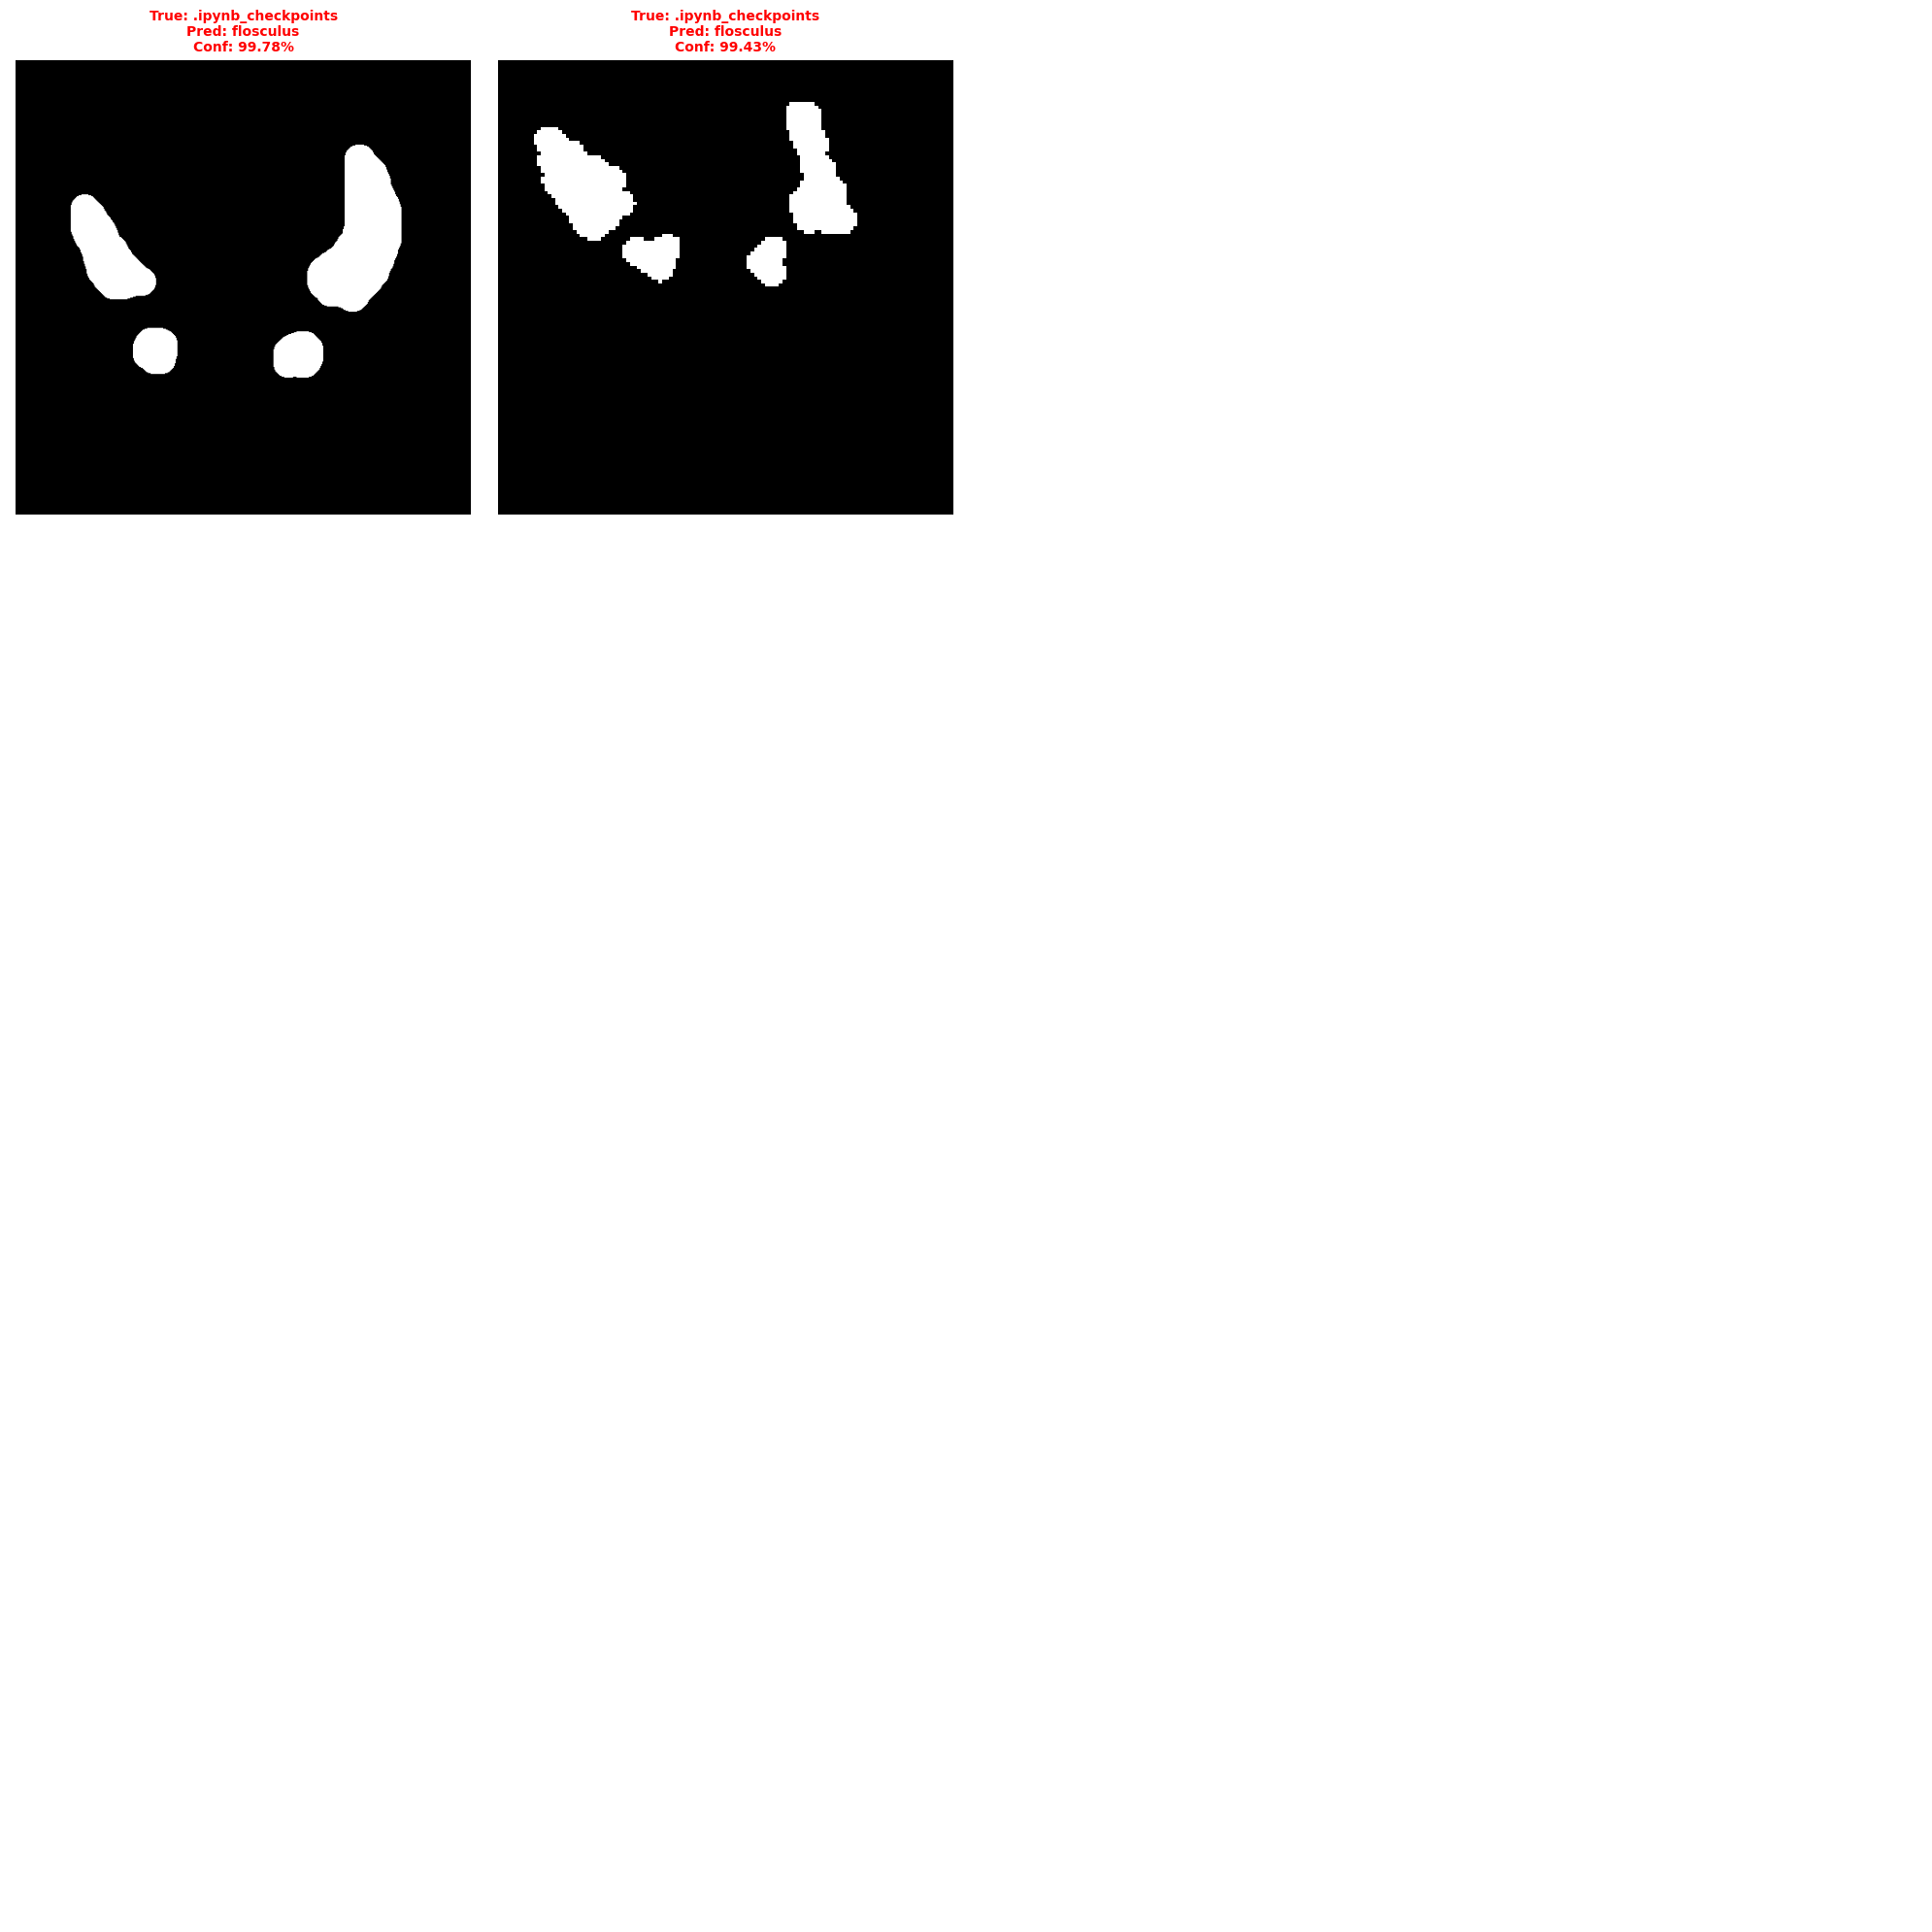


Accuracy on sample: 0.00% (0/2)


In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
import os

model.load_state_dict(torch.load('rituals_pytorch.pth'))
model.eval()
model.to(device)

def predict_image(image_path, model, device):
    """Prédit la classe d'une image"""
    img = load_and_preprocess_image(image_path)
    
    img_tensor = torch.FloatTensor(img).unsqueeze(0).unsqueeze(0) / 255.0
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    return predicted.item(), confidence.item(), probabilities[0].cpu().numpy()

def test_on_folder(test_folder_path, model, label_names, device, num_images=16):
    """Teste le modèle sur un dossier et affiche les résultats"""
    
    all_images = []
    true_labels = []
    
    for label in os.listdir(test_folder_path):
        label_path = os.path.join(test_folder_path, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_images.append(os.path.join(label_path, filename))
                    true_labels.append(label)
    
    indices = np.random.choice(len(all_images), min(num_images, len(all_images)), replace=False)
    
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    axes = axes.flatten()
    
    correct = 0
    total = 0
    
    for idx, img_idx in enumerate(indices):
        image_path = all_images[img_idx]
        true_label = true_labels[img_idx]
        
        pred_idx, confidence, probabilities = predict_image(image_path, model, device)
        pred_label = label_names[pred_idx]
        
        img_display = Image.open(image_path).convert('L')
        
        is_correct = (pred_label == true_label)
        if is_correct:
            correct += 1
        total += 1
        
        axes[idx].imshow(img_display, cmap='gray')
        axes[idx].axis('off')
        
        color = 'green' if is_correct else 'red'
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}"
        axes[idx].set_title(title, fontsize=10, color=color, weight='bold')
    
    for idx in range(len(indices), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    accuracy = correct / total * 100
    print(f"\nAccuracy on sample: {accuracy:.2f}% ({correct}/{total})")
    
    return accuracy

test_folder_path = "test" 
accuracy = test_on_folder(test_folder_path, model, label_names, device, num_images=16)